In [1]:
from model import FullQuantumModel, QuantumCircuit
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#states of 8 qubits
for i in range(256):
    print(format(i, '08b'))

00000000
00000001
00000010
00000011
00000100
00000101
00000110
00000111
00001000
00001001
00001010
00001011
00001100
00001101
00001110
00001111
00010000
00010001
00010010
00010011
00010100
00010101
00010110
00010111
00011000
00011001
00011010
00011011
00011100
00011101
00011110
00011111
00100000
00100001
00100010
00100011
00100100
00100101
00100110
00100111
00101000
00101001
00101010
00101011
00101100
00101101
00101110
00101111
00110000
00110001
00110010
00110011
00110100
00110101
00110110
00110111
00111000
00111001
00111010
00111011
00111100
00111101
00111110
00111111
01000000
01000001
01000010
01000011
01000100
01000101
01000110
01000111
01001000
01001001
01001010
01001011
01001100
01001101
01001110
01001111
01010000
01010001
01010010
01010011
01010100
01010101
01010110
01010111
01011000
01011001
01011010
01011011
01011100
01011101
01011110
01011111
01100000
01100001
01100010
01100011
01100100
01100101
01100110
01100111
01101000
01101001
01101010
01101011
01101100
01101101
01101110
0

In [3]:
#Model instantiation
num_qubits = 8
num_layers = 6
model = FullQuantumModel(qubits=num_qubits, layers=num_layers, num_classes=4)

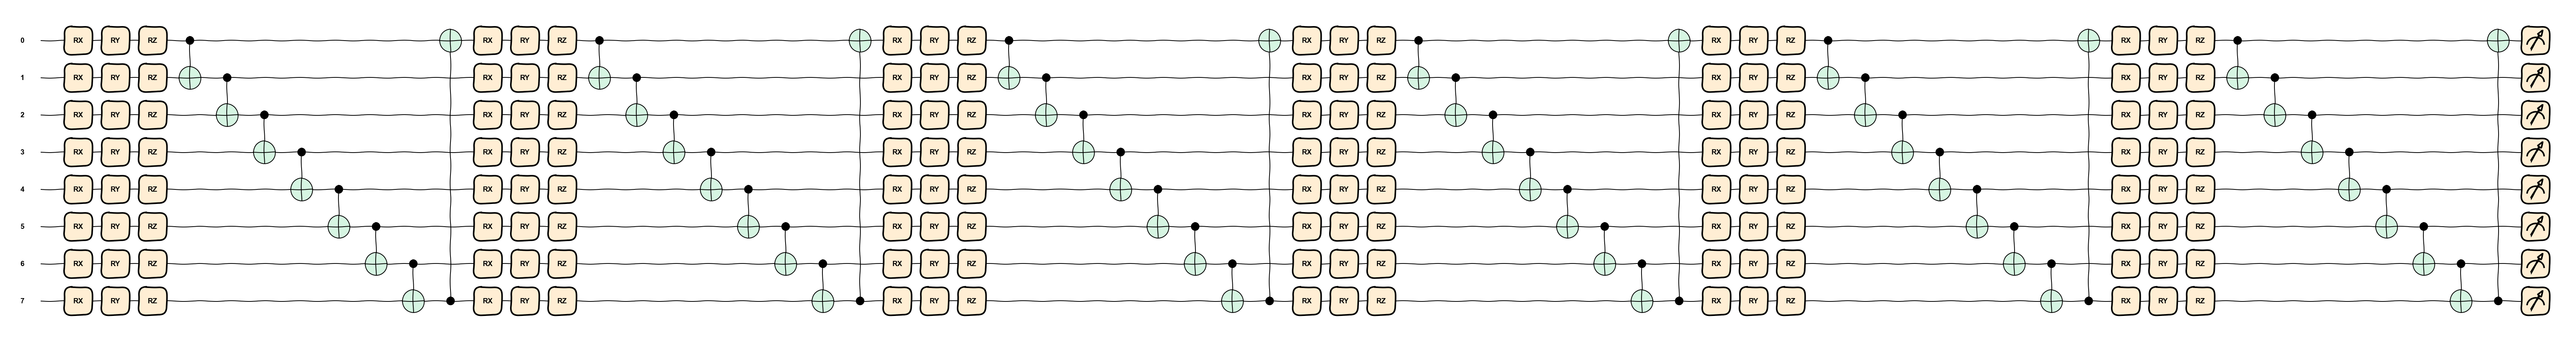

In [27]:
model.draw(style = 'sketch')

In [5]:
model.trainable_parameters()

Trainable parameters: 144


# Dataset preparation

In [5]:
labels = [0,1,2,3]

In [6]:
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))

In [7]:
train_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.8,batch_size=64)

# Model training

A tutorial on how to train the model with the different functionalities is hereafter reported:

In [ ]:
# 'normal' training of the whole model
model.fit(dataloader=train_dataloader, learning_rate=0.01, epochs=8, show_plot=True)

Epoch 1/1: 100%|██████████| 309/309 [00:20<00:00, 15.27it/s, accuracy=0.375, loss=1.35]


Time per epoch:  20.237196922302246
Epoch:  1 Loss:  1.3572715088773313
Accuracy:  0.42056027508090615
--------------------------------------------------------------------------


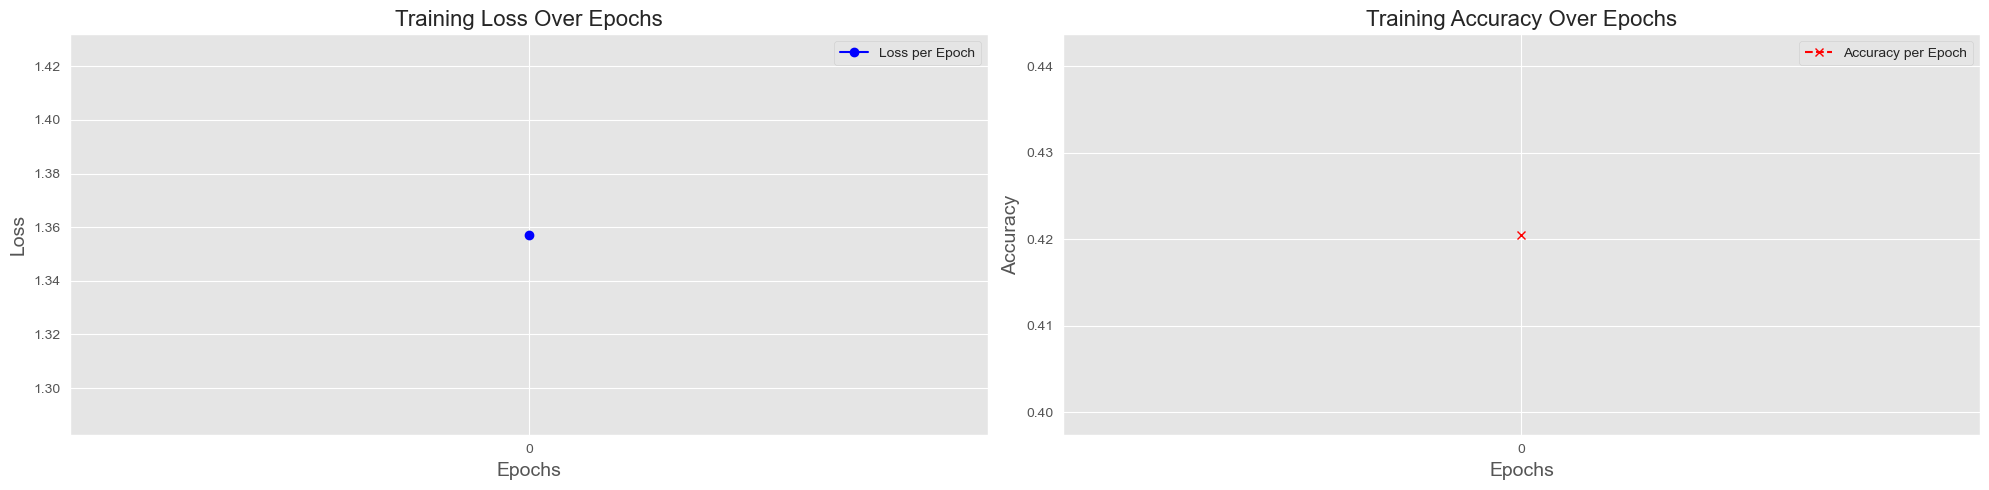

([0.42056027508090615], [1.3572715088773313])

In [18]:
# training of the model up to the forth layer: take prediction after four layers and train only the layer before that
model.fit(dataloader=train_dataloader, learning_rate=0.0001, epochs=1, num_layers_to_execute=4, show_plot=True)

Epoch 1/1: 100%|██████████| 309/309 [00:10<00:00, 28.64it/s, accuracy=0.328, loss=1.39]


Time per epoch:  10.7912437915802
Epoch:  1 Loss:  1.399593183137838
Accuracy:  0.30491504854368934
--------------------------------------------------------------------------


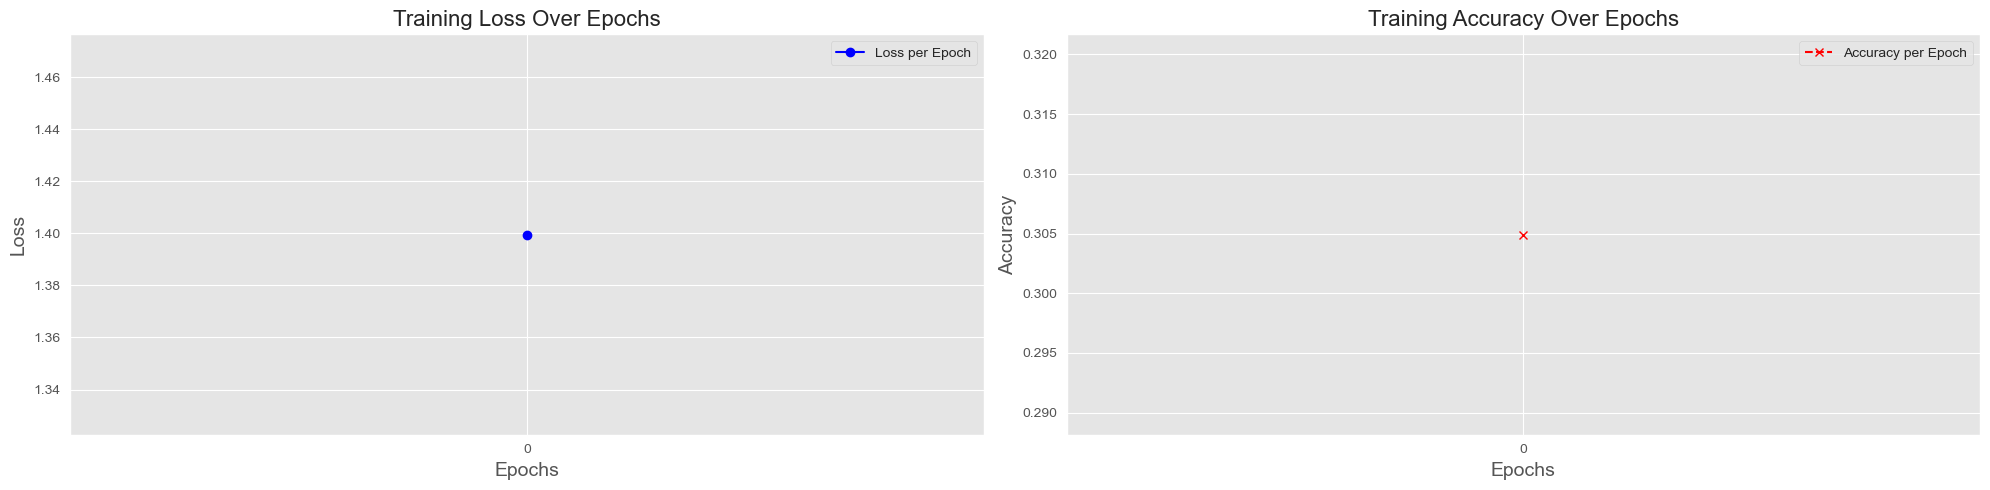

([0.30491504854368934], [1.399593183137838])

In [19]:
# training of the model up to the forth layer: take prediction after second layers and train only the layer before that
model.fit(dataloader=train_dataloader, learning_rate=0.0001, epochs=1, num_layers_to_execute=2, show_plot=True)

# Test

In [20]:
#freeze the layer after that the previous cell has already freeze all but the first two
model.freeze_layers([0,1])
model.trainable_parameters()

Trainable parameters: 0


In [21]:
#set a threshold for confidence value
threshold = 0.3

#save prediction of the test set, there is an early exit on layer 2 and 4
#that will be used when the confidence will be adequately high, i.e. the 
#probabilty associated to one of the possible states is greater than the
#threshold

results = {
    '2_layers': [],
    '4_layers': [],
    '6_layers': []
}

for img, label in tqdm(test_dataloader.dataset): 
    img = img / torch.linalg.norm(img).view(-1, 1)
    
    #forward pass until the first 2 layers
    probs = model.forward(state=img, num_layers_to_execute=2)
    prediction = torch.argmax(probs, dim=1)
    confidence = probs[0, prediction]
    
    if confidence > threshold:
        results['2_layers'].append((prediction, label))
    else: 
        #forward pass until the 4 layer
        probs = model.forward(state=img, num_layers_to_execute=4)
        prediction = torch.argmax(probs, dim=1)
        confidence = probs[0, prediction]
        
        if confidence > threshold:
            results['4_layers'].append((prediction, label))
        
        else:
            probs = model.forward(state=img, num_layers_to_execute=6)
            prediction = torch.argmax(probs, dim=1)
            results['6_layers'].append((prediction,label))

100%|██████████| 4951/4951 [01:12<00:00, 67.87it/s]


In [22]:
#define a function to calculate accuracy

def calculate_accuracy(data):
    correct = sum([1 for label, prediction in data if label == prediction])
    return correct, correct / len(data) if len(data) > 0 else 0

correct_2_layers, accuracy_2_layers = calculate_accuracy(results['2_layers'])
correct_4_layers, accuracy_4_layers = calculate_accuracy(results['4_layers'])
correct_6_layers, accuracy_6_layers = calculate_accuracy(results['6_layers'])

print(f"{len(results['2_layers'])} elements in 2 layers with Accuracy : {accuracy_2_layers}")

print(f"{len(results['4_layers'])} elements in 4 layers with Accuracy : {accuracy_4_layers}")

print(f"{len(results['6_layers'])} elements in 2 layers with Accuracy : {accuracy_6_layers}")

print(f"Overall accuracy: {(correct_2_layers+correct_4_layers+correct_6_layers)/len(test_dataloader.dataset)}")

3195 elements in 2 layers with Accuracy : 0.3114241001564945
239 elements in 4 layers with Accuracy : 0.7698744769874477
1517 elements in 2 layers with Accuracy : 0.914963744232037
Overall accuracy: 0.5184811149262775


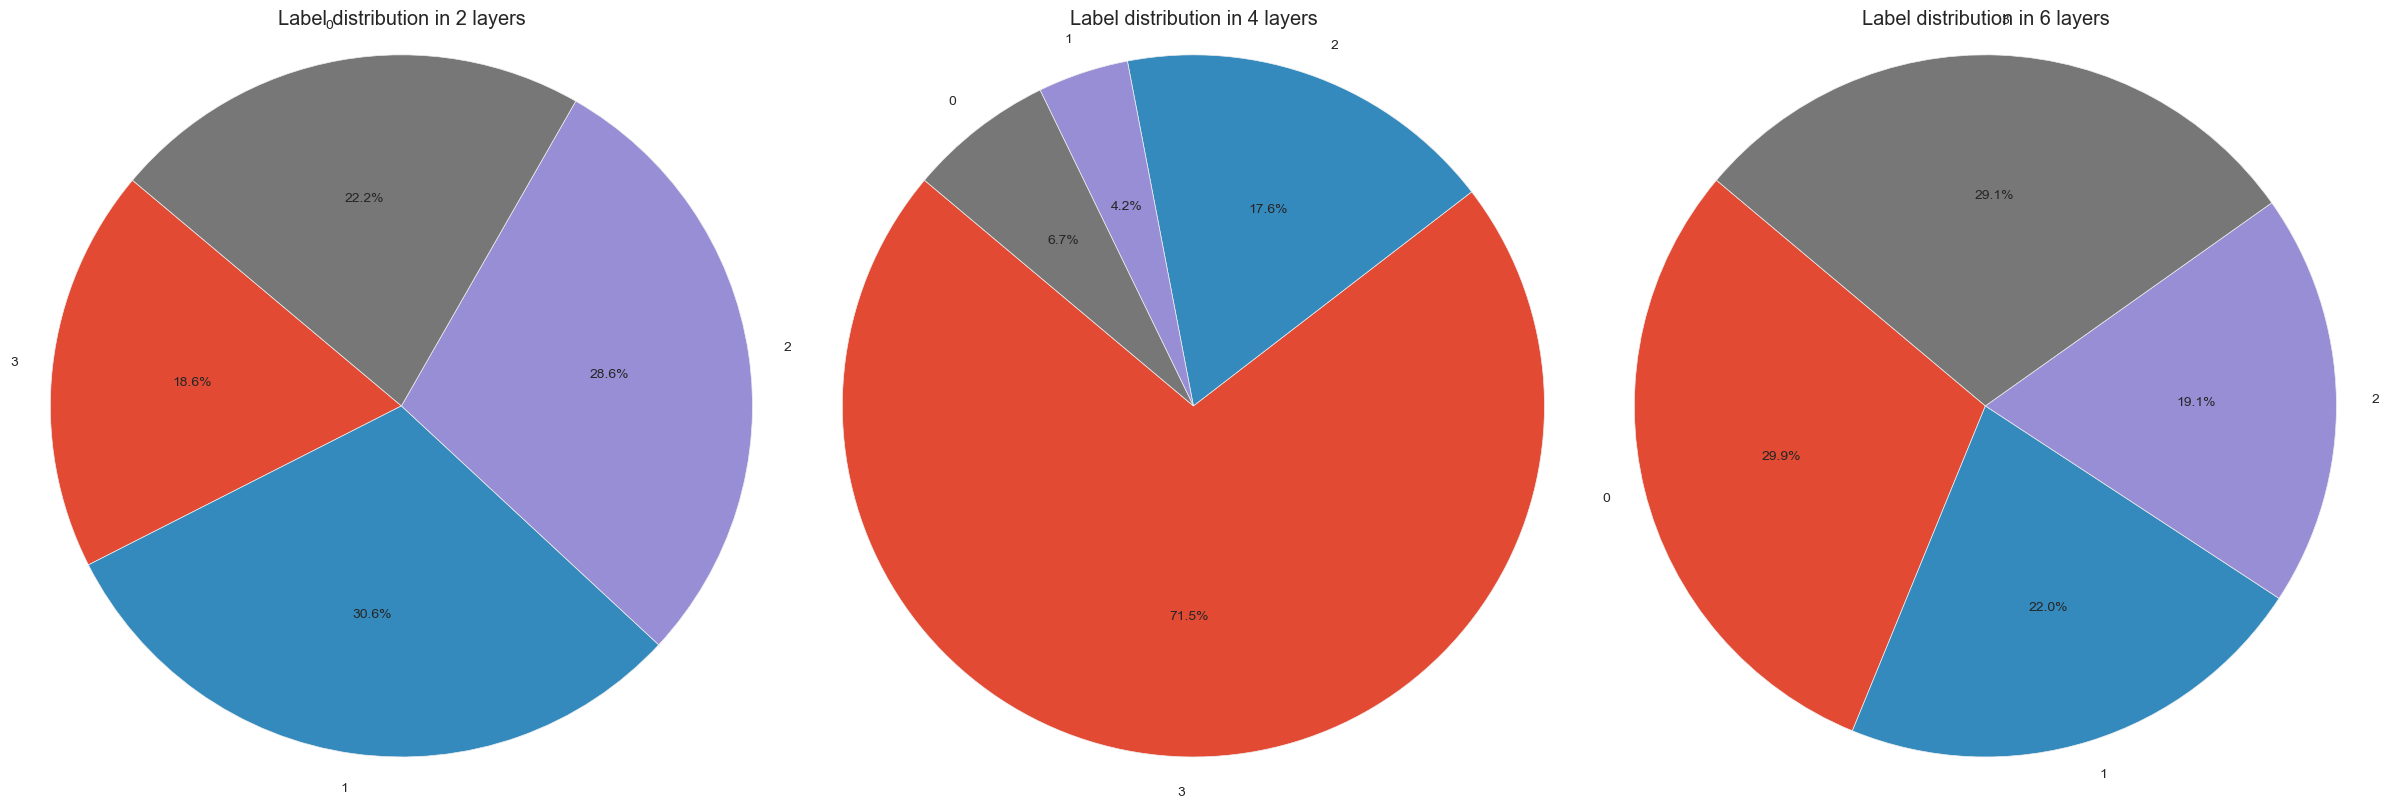

In [25]:
#pie chart to display the distribution of labels that are classified in each exit 
def plot_pie_charts(results):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 

    
    titles = ["Label distribution in 2 layers", "Label distribution in 4 layers", "Label distribution in 6 layers"]
    
    for idx, key in enumerate(['2_layers', '4_layers', '6_layers']):
        data = results[key]
        labels, counts = zip(*Counter([label.item() for _, label in data]).items())
        axes[idx].pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
        axes[idx].set_title(titles[idx])
        axes[idx].axis('equal') 

    plt.tight_layout()
    plt.show()


plot_pie_charts(results)

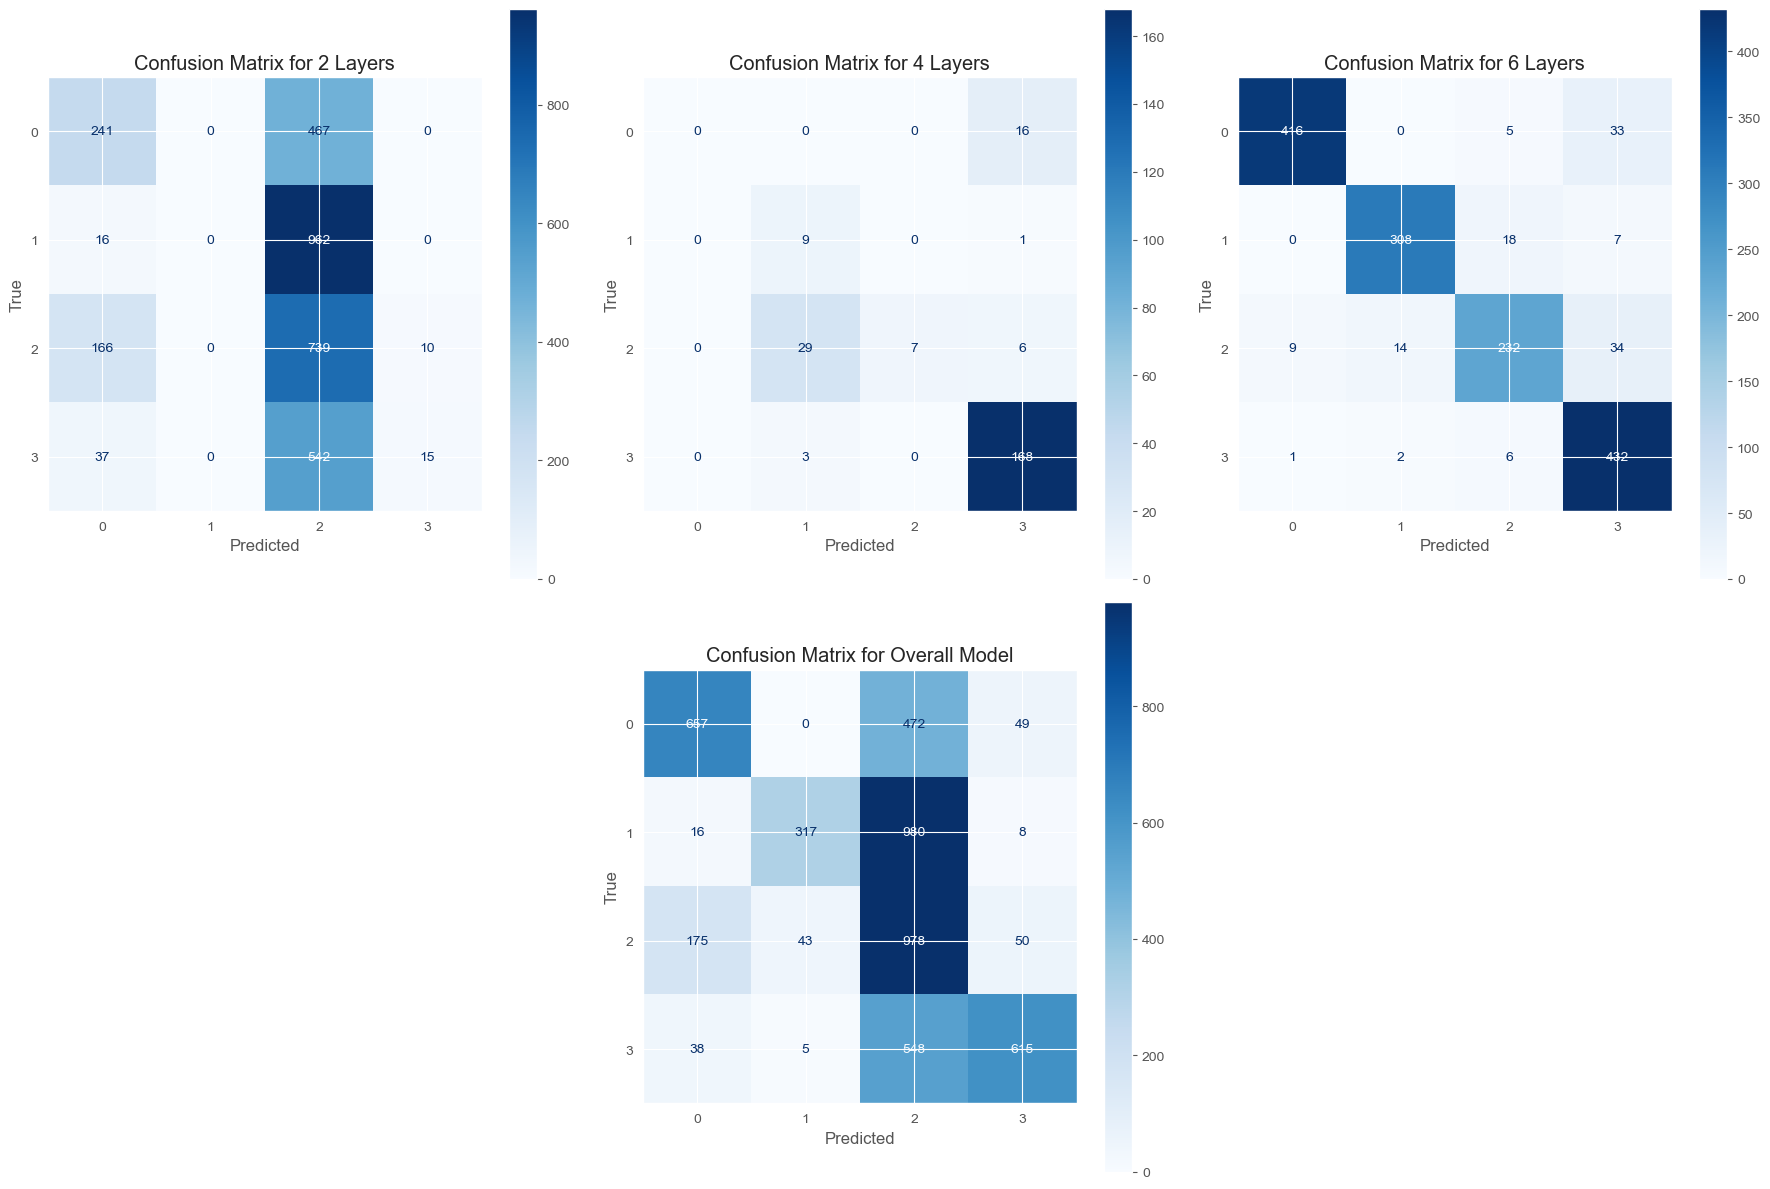

In [26]:
#confusion matrix 

results = {
    '2_layers': [(torch.tensor([pred]), torch.tensor([label])) for pred, label in results['2_layers']],
    '4_layers': [(torch.tensor([pred]), torch.tensor([label])) for pred, label in results['4_layers']],
    '6_layers': [(torch.tensor([pred]), torch.tensor([label])) for pred, label in results['6_layers']]
}

def plot_confusion_matrix(results, layer_name, ax):
    all_preds = torch.cat([x[0] for x in results])
    all_labels = torch.cat([x[1] for x in results])
    
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {layer_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


fig, axes = plt.subplots(2, 3, figsize=(18, 12))


plot_confusion_matrix(results['2_layers'], '2 Layers', axes[0, 0])
plot_confusion_matrix(results['4_layers'], '4 Layers', axes[0, 1])
plot_confusion_matrix(results['6_layers'], '6 Layers', axes[0, 2])

all_results = results['2_layers'] + results['4_layers'] + results['6_layers']
plot_confusion_matrix(all_results, 'Overall Model', axes[1, 1])

fig.delaxes(axes[1, 0])
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()